In [116]:
import pandas as pd

In [117]:
#Lendo a base de treino
train_selecionada = pd.read_csv("train_selecionada.csv")
#lendo a base de teste oos
test_oos = pd.read_csv("test_oos.csv")
test_oos = test_oos[train_selecionada.columns]

In [118]:
train_selecionada['VAR_1']

0         0.0
1       171.0
2        56.0
3        36.0
4        30.0
        ...  
7310     10.0
7311     59.0
7312     20.0
7313    109.0
7314      0.0
Name: VAR_1, Length: 7315, dtype: float64

In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from optbinning import OptimalBinning
from sklearn.cluster import KMeans
from typing import Tuple, Dict, List

def train_woe_binning(
    df: pd.DataFrame, 
    variables: List[str], 
    target: str, 
    time_variable: str, 
    n_clusters: int = 4,
    plot_vars: List[str] = None
) -> Tuple[pd.DataFrame, Dict]:
    
    df_result = df.copy()
    binning_rules = {}

    for variable in variables:
        # 1️⃣ Treinando o binning de WOE
        binning = OptimalBinning(name=variable, dtype="numerical", solver="cp")
        binning.fit(df[variable], df[target])

        # Aplicando o binning para obter os bins
        df_result[f"{variable}_bin"] = binning.transform(df[variable], metric="bins")

        # 2️⃣ Criando DataFrame para análise de estabilidade
        stability_df = df_result.groupby([time_variable, f"{variable}_bin"]).size().unstack().fillna(0)
        stability_df = stability_df.div(stability_df.sum(axis=1), axis=0)

        # 🚨 Ajustando o número de clusters para não exceder a quantidade de bins
        num_bins = len(stability_df.columns)
        adjusted_clusters = min(n_clusters, num_bins)  # Garante que n_clusters não seja maior que o número de bins
        
        if adjusted_clusters < 2:
            print(f"⚠️ Aviso: {variable} tem apenas {num_bins} bins. Não será clusterizada.")
            bin_map = {bin_label: f"Bin_1" for bin_label in stability_df.columns}
        else:
            # 3️⃣ Clusterizando bins com comportamento semelhante
            kmeans = KMeans(n_clusters=adjusted_clusters, random_state=42, n_init=10)
            bin_clusters = kmeans.fit_predict(stability_df.T)
            bin_map = {bin_label: f"Bin_{cluster+1}" for bin_label, cluster in zip(stability_df.columns, bin_clusters)}
        
        df_result[f"{variable}_bin_group"] = df_result[f"{variable}_bin"].map(bin_map)

        # 4️⃣ Criando as regras de transformação
        bin_edges = binning.splits
        bin_labels = sorted(df_result[f"{variable}_bin"].unique())
        bin_cluster_map = {bin_: bin_map[bin_] for bin_ in bin_labels}

        binning_rules[variable] = {
            "edges": bin_edges,
            "labels": bin_labels,
            "bin_to_group": bin_cluster_map
        }

        # 5️⃣ Plotando estabilidade antes e depois do agrupamento
        if plot_vars is None or variable in plot_vars:
            stability_grouped_df = df_result.groupby([time_variable, f"{variable}_bin_group"]).size().unstack().fillna(0)
            stability_grouped_df = stability_grouped_df.div(stability_grouped_df.sum(axis=1), axis=0)

            fig, axes = plt.subplots(1, 2, figsize=(14, 5))
            stability_df.plot(ax=axes[0], marker='o')
            axes[0].set_title(f"Distribuição de {variable} ao Longo do Tempo (Antes do Agrupamento)")
            axes[0].set_ylabel("Proporção")
            axes[0].set_xlabel("Safra")

            stability_grouped_df.plot(ax=axes[1], marker='o', cmap="tab10")
            axes[1].set_title(f"Distribuição de {variable} ao Longo do Tempo (Depois do Agrupamento)")
            axes[1].set_ylabel("Proporção")
            axes[1].set_xlabel("Safra")

            plt.tight_layout()
            plt.show()

    return df_result, binning_rules


In [120]:
VArs_instaveis = ['VAR_15','VAR_9', 'VAR_54', 'VAR_3', 'VAR_5', 'VAR_1', 'VAR_28','VAR_60',
 'VAR_58','VAR_17', 'VAR_30', 'VAR_2', 'VAR_59','VAR_53', 'VAR_20', 'VAR_57', 'VAR_44', 'VAR_52', 'VAR_76', 'VAR_4']

In [107]:
VArs_instaveis = ['VAR_15','VAR_9', 'VAR_54','VAR_28']

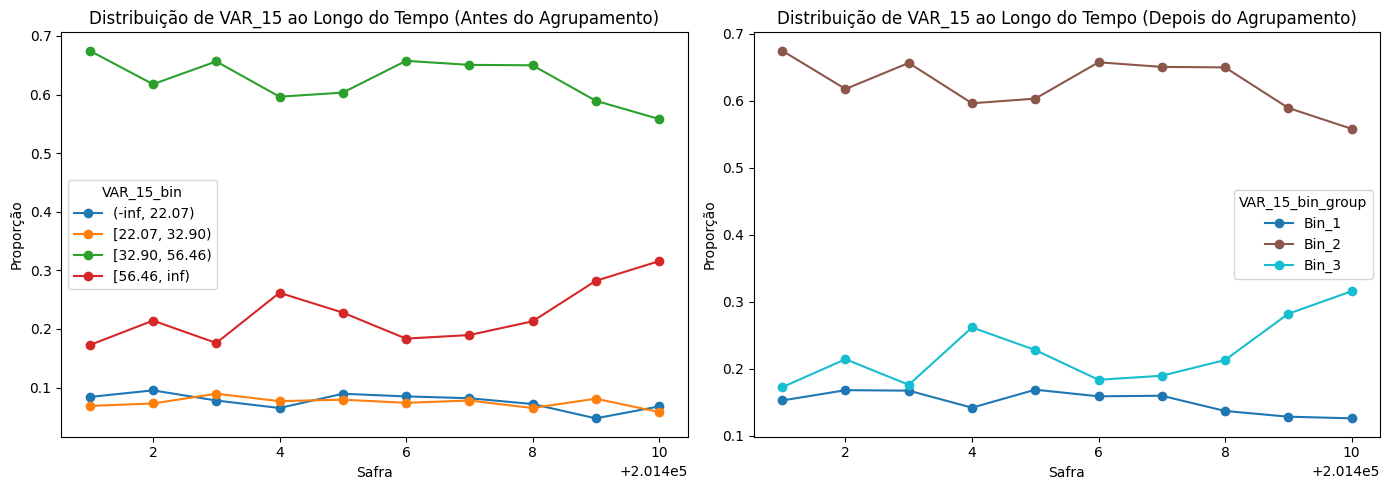

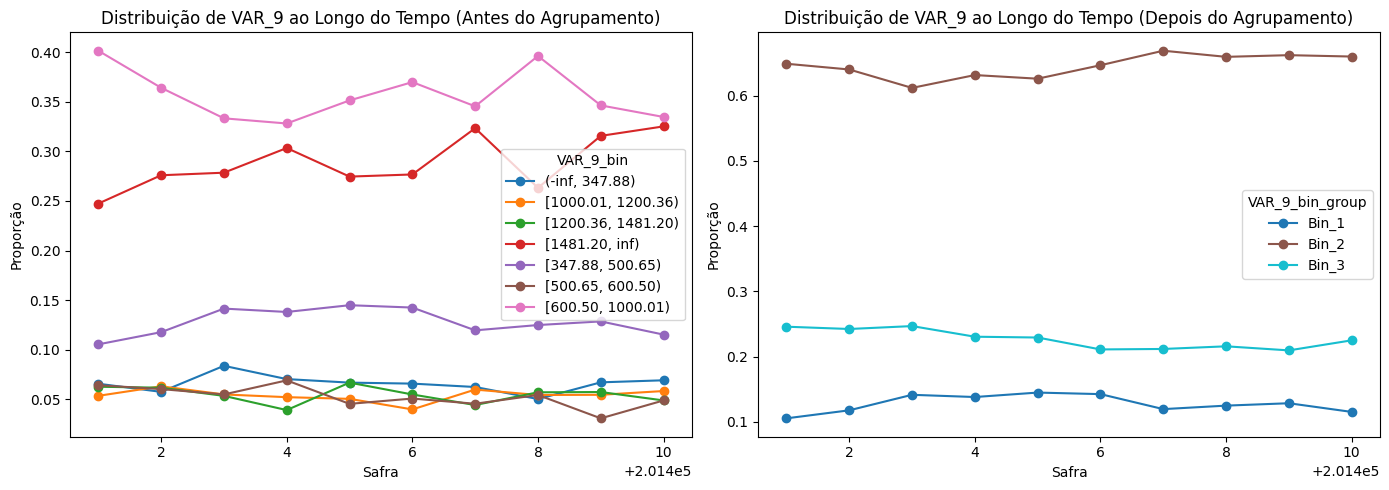

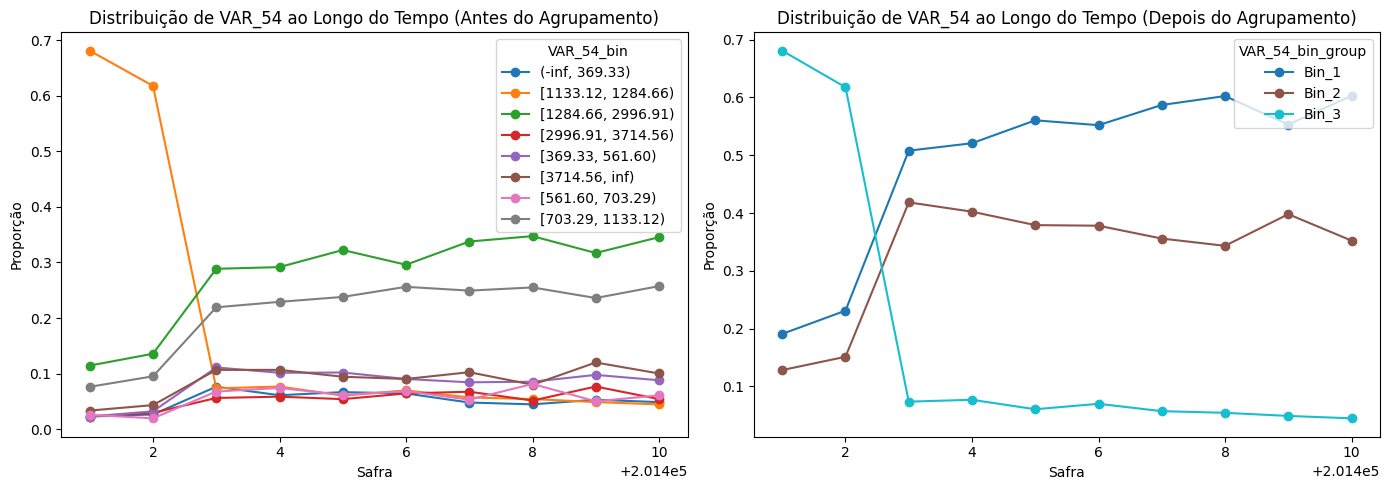

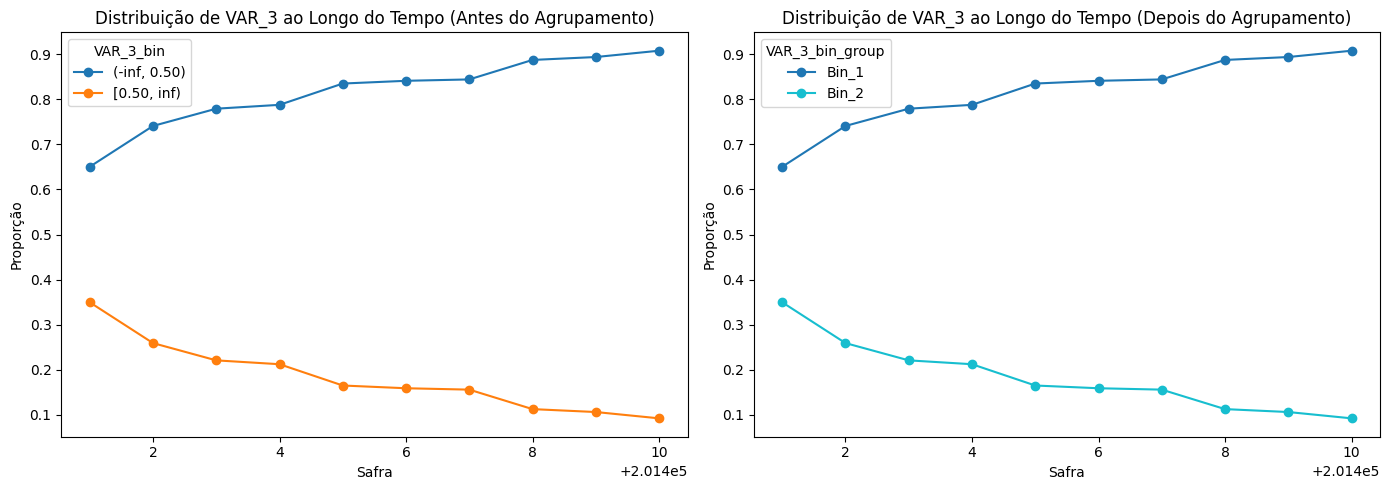

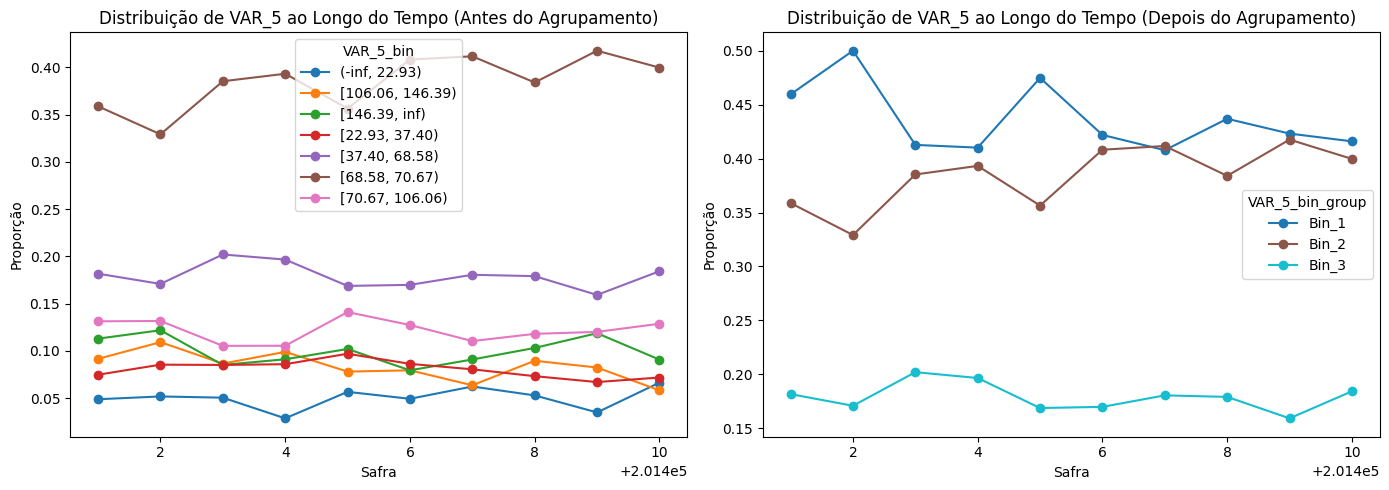

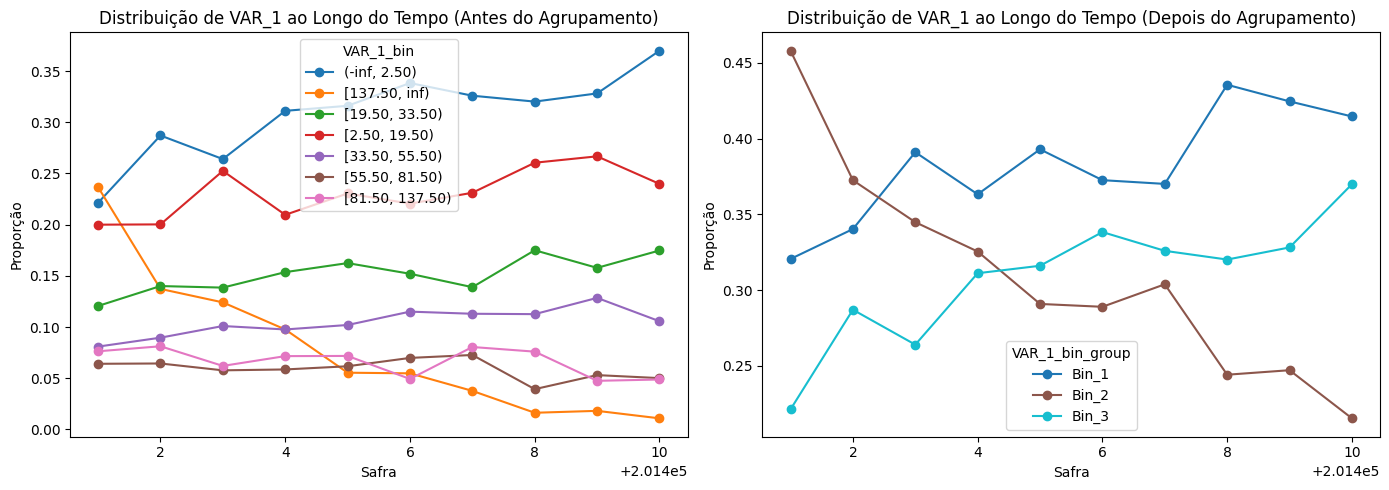

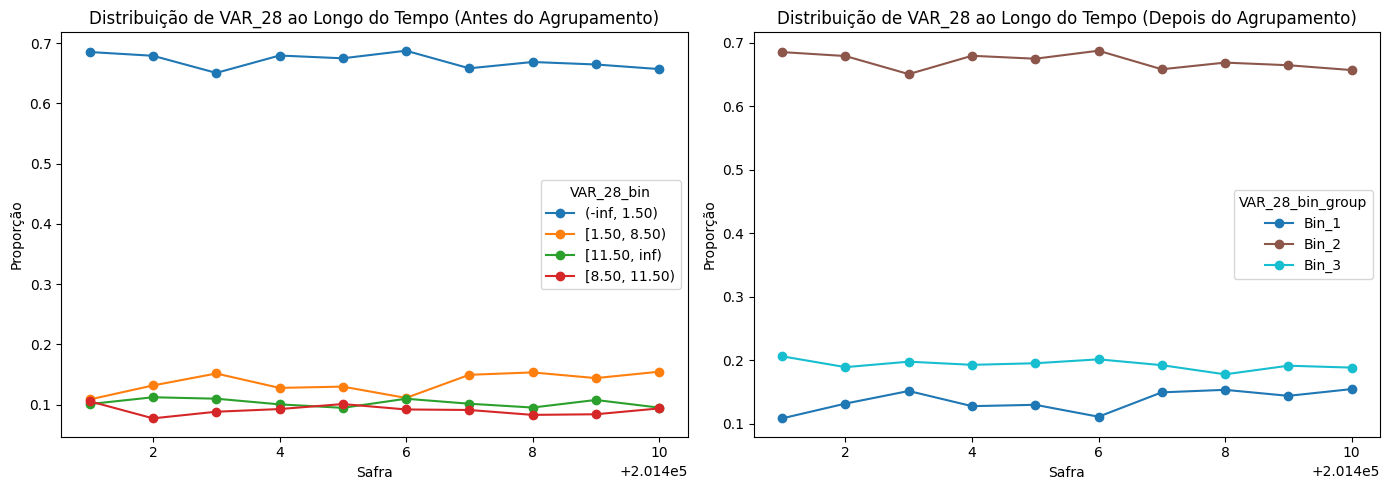

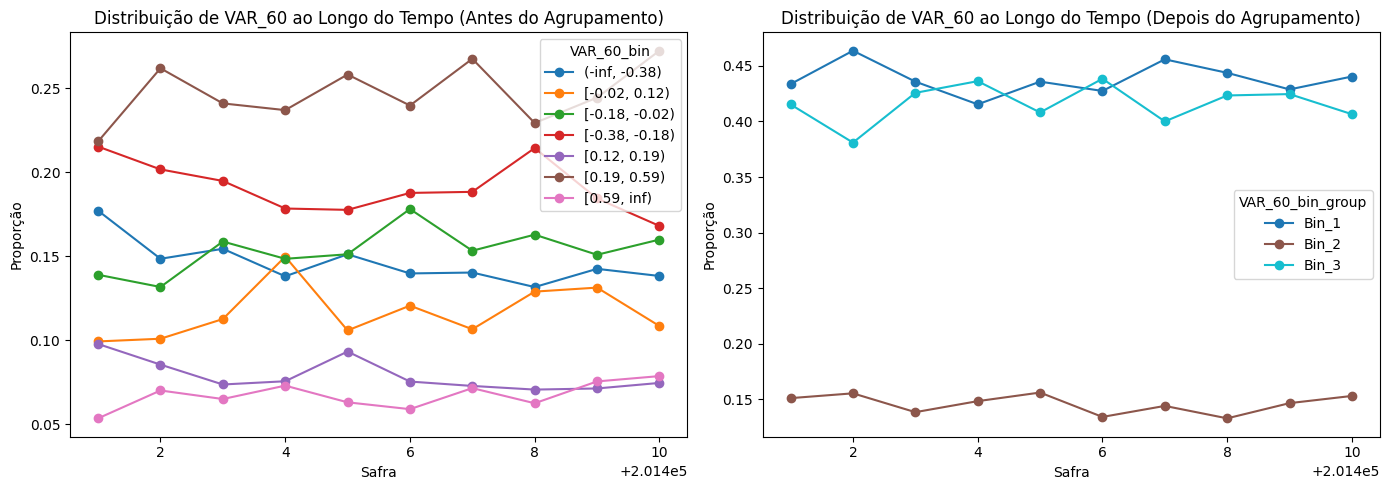

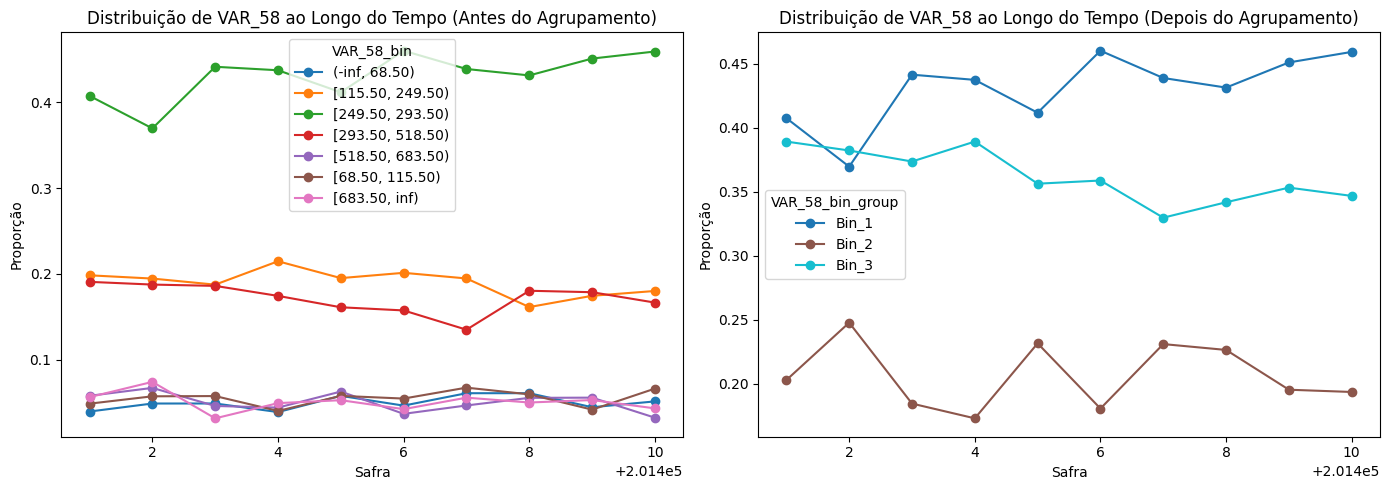

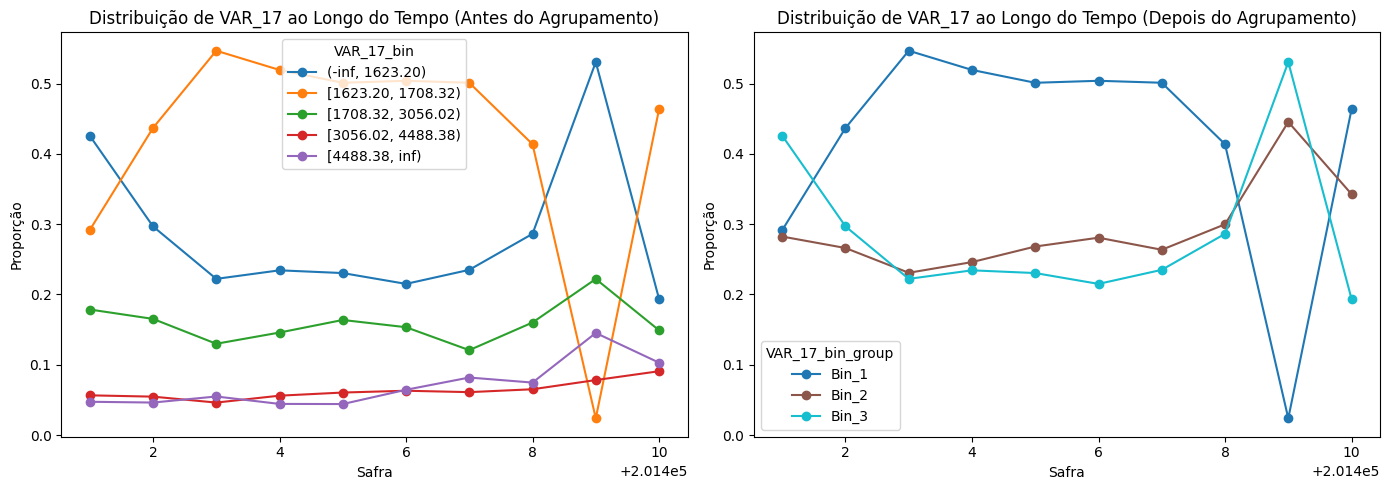

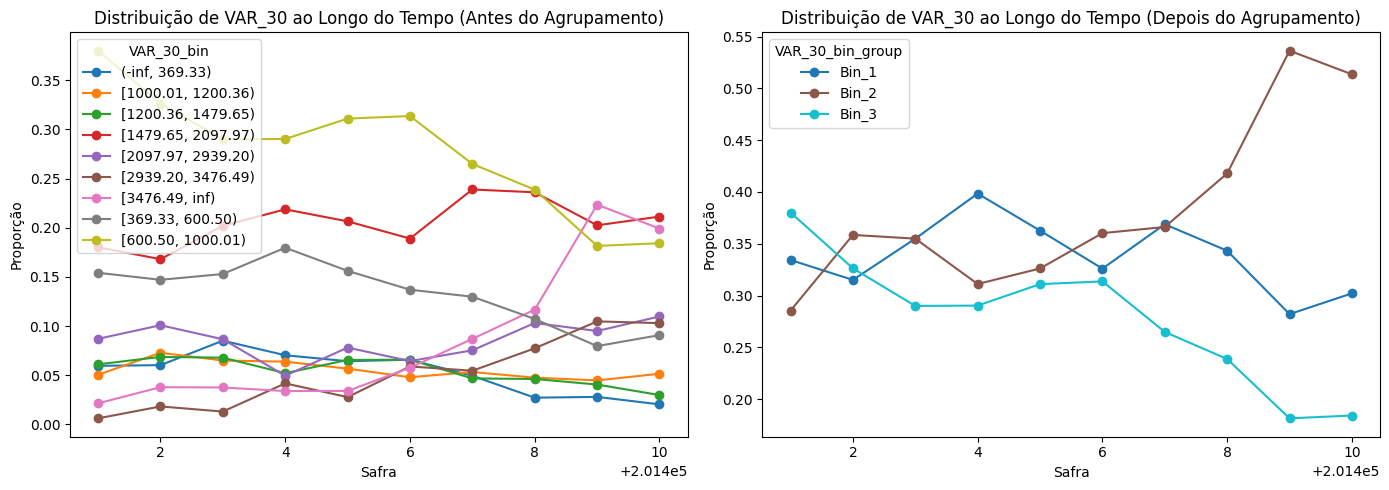

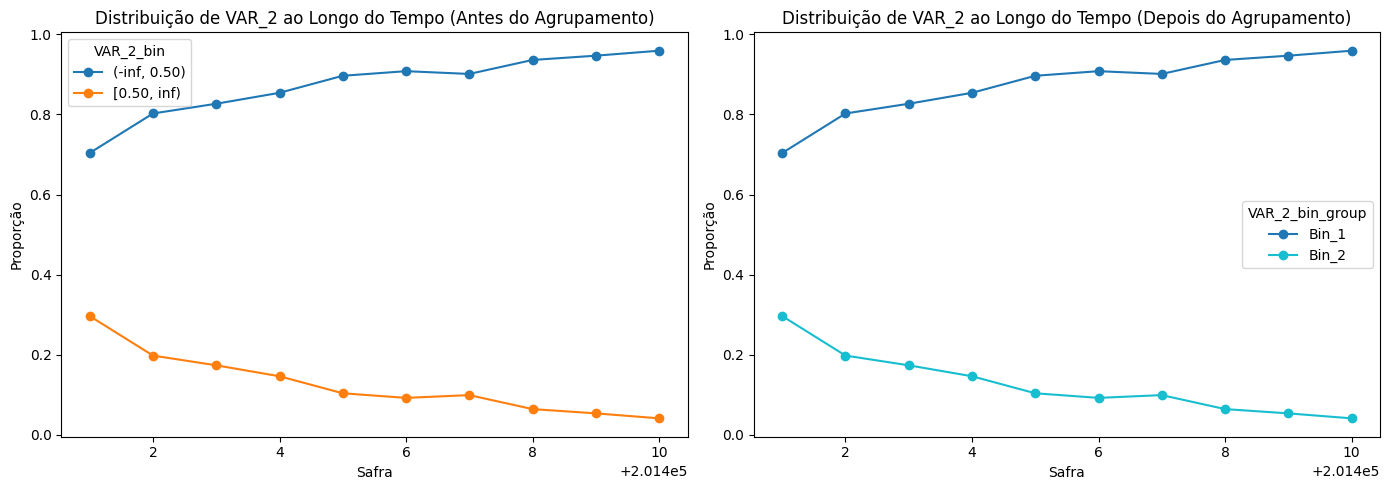

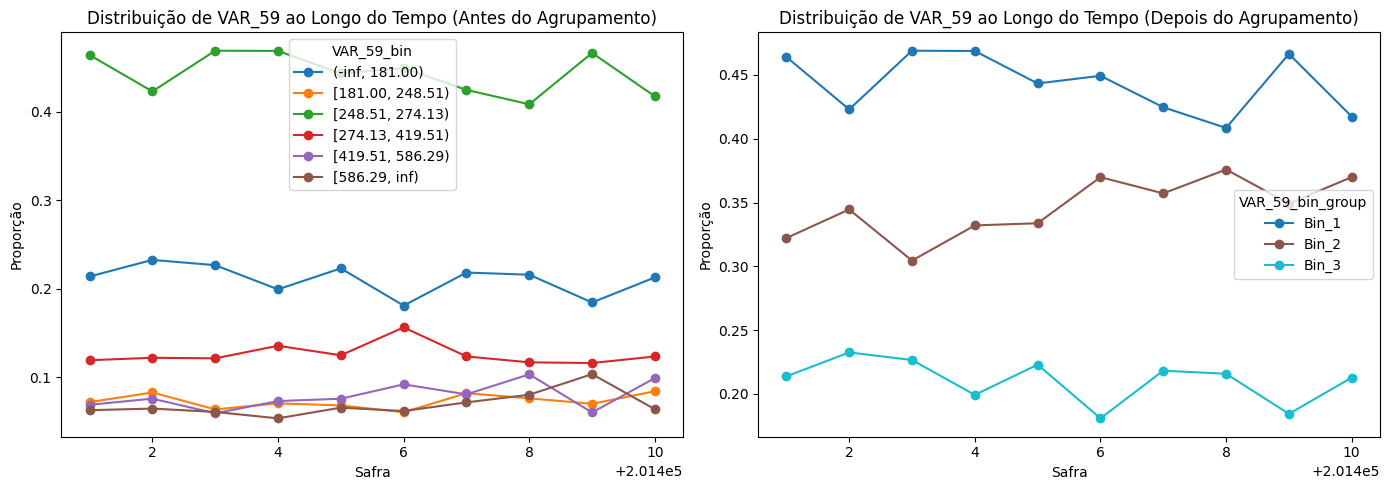

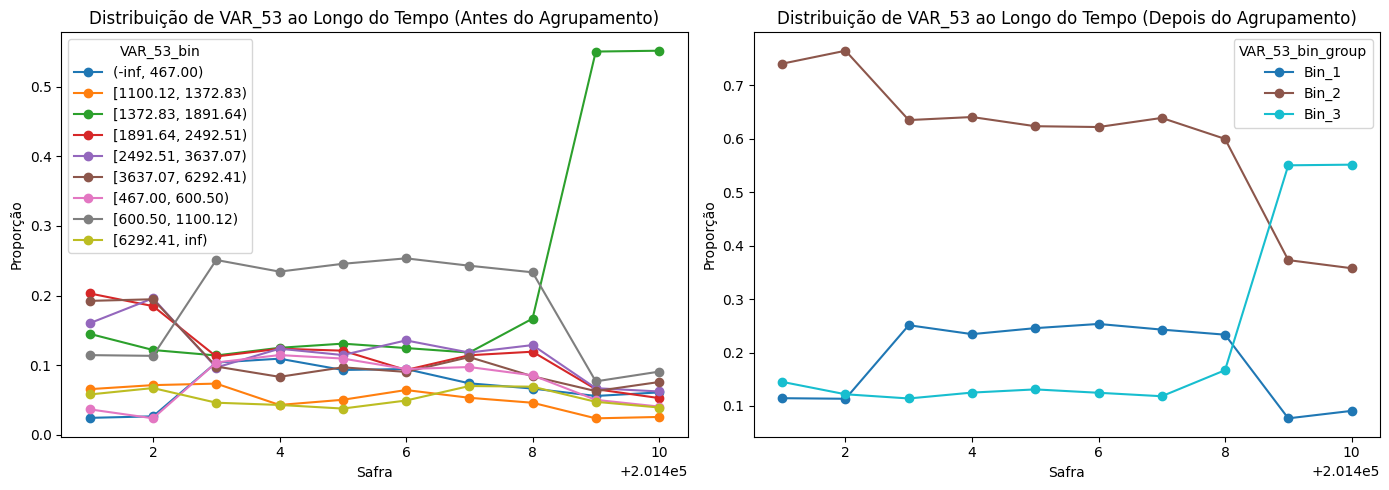

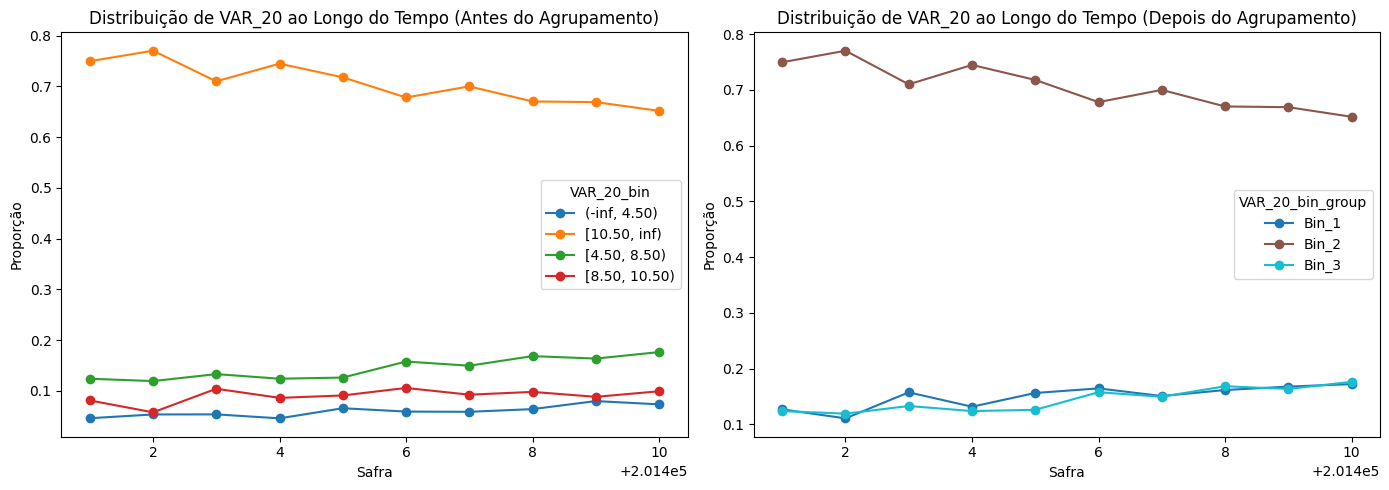

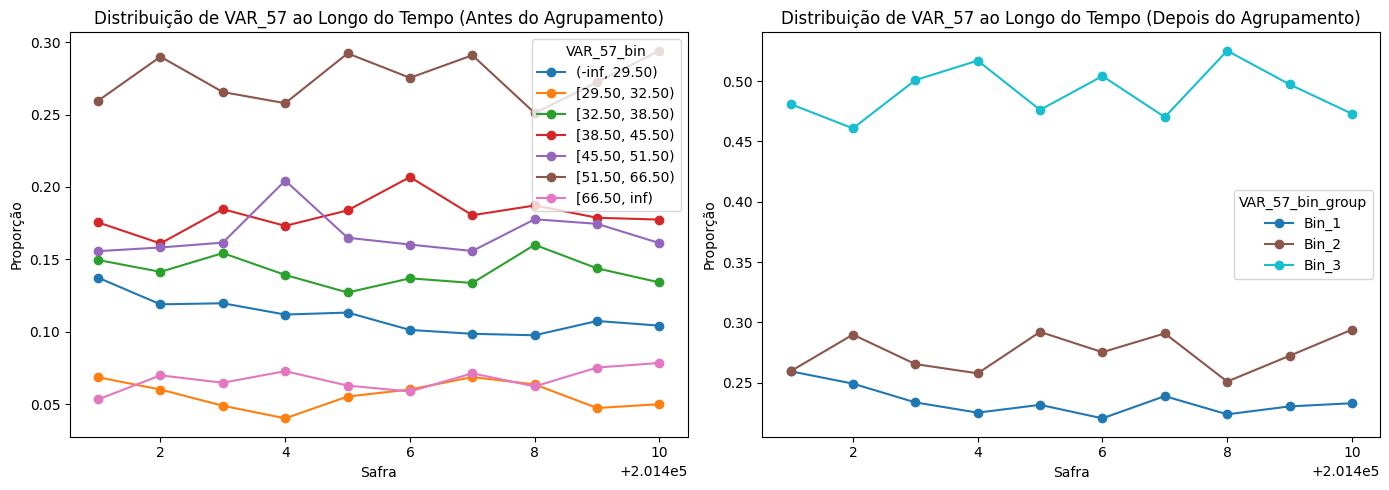

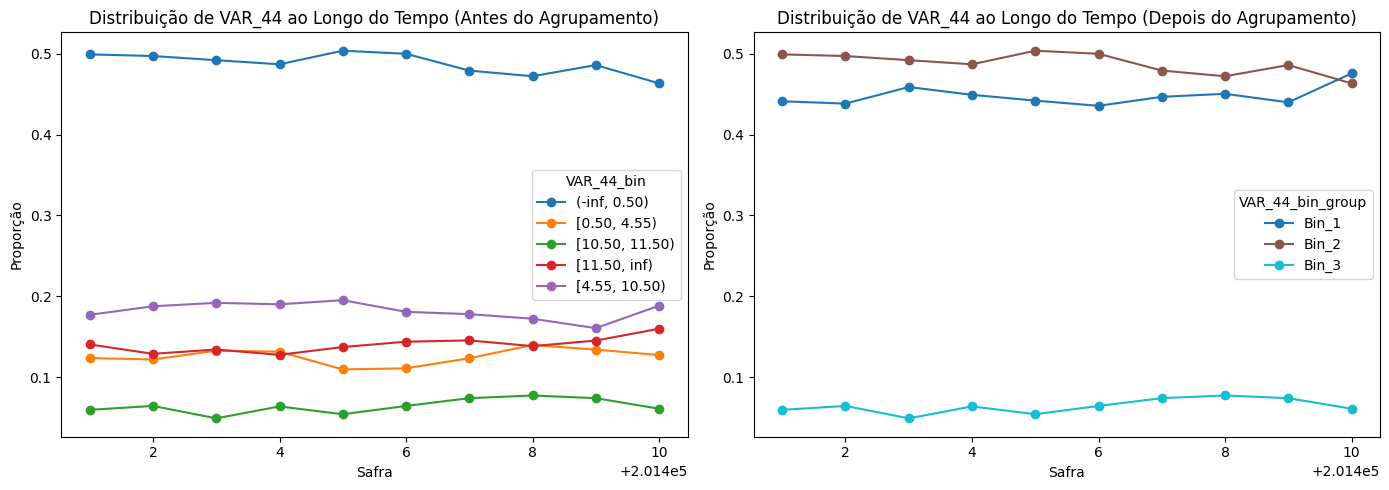

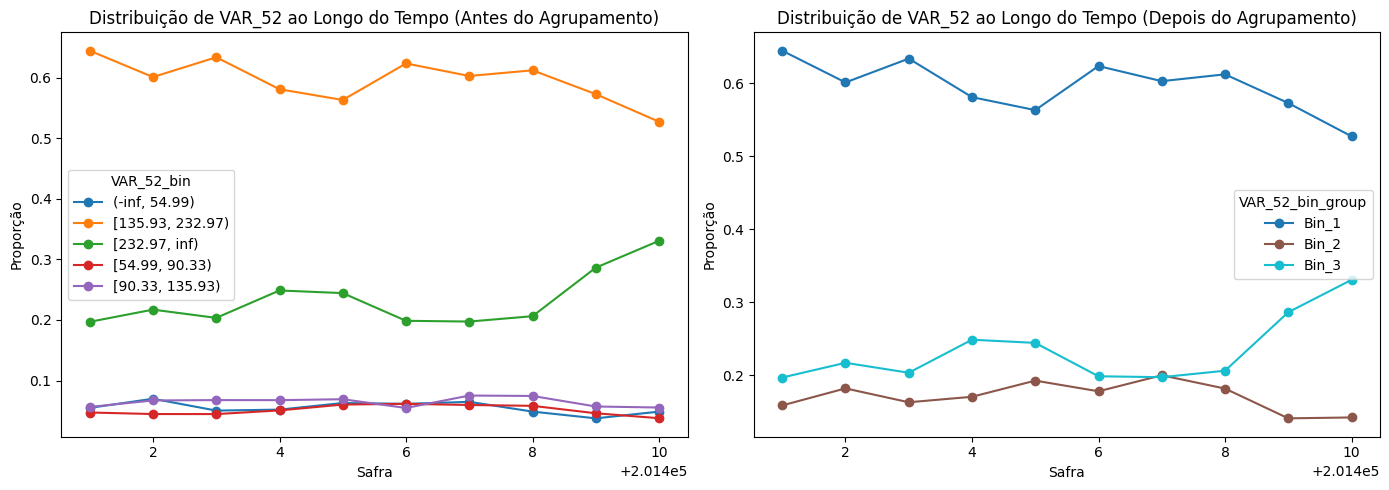

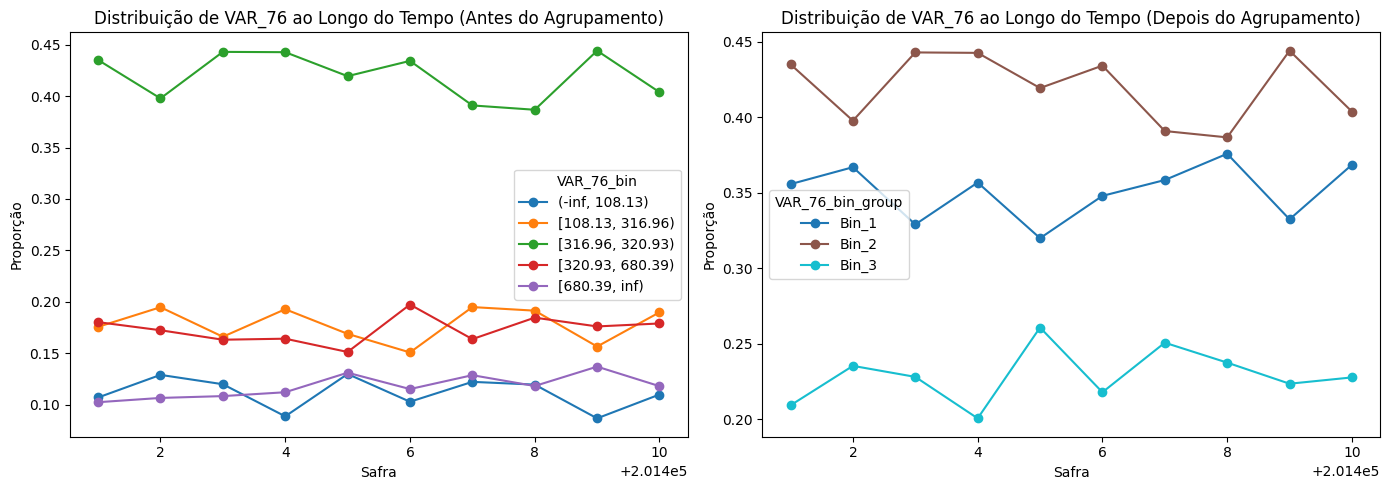

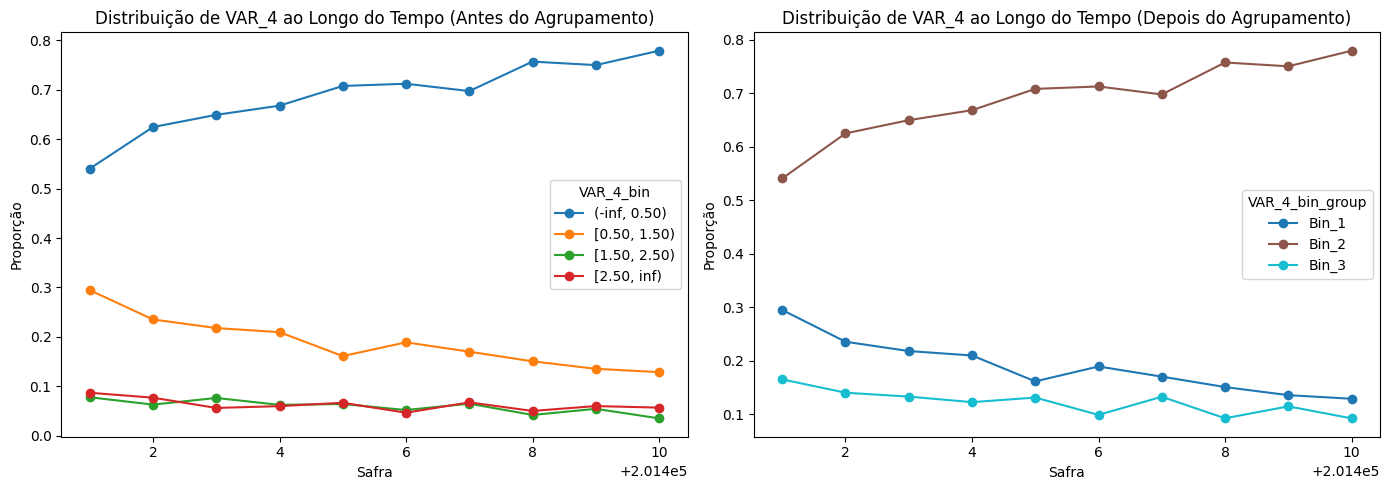

In [122]:
df_result, binning_rules = train_woe_binning(
        df=train_selecionada, 
        variables=VArs_instaveis, 
        target='y', 
        time_variable='safra', 
        n_clusters= 3,
        plot_vars = VArs_instaveis
)

In [111]:
df_result

,id,safra,y,VAR_15,VAR_9,VAR_54,VAR_3,VAR_5,VAR_1,VAR_28,...,VAR_64,VAR_22,VAR_15_bin,VAR_15_bin_group,VAR_9_bin,VAR_9_bin_group,VAR_54_bin,VAR_54_bin_group,VAR_28_bin,VAR_28_bin_group
0,7913,201405,0,80.41,700.00,700.00,0.0,73.96,0.0,0.0,...,0,0.0,"[56.46, inf)",Bin_3,"[600.50, 1000.01)",Bin_2,"[561.60, 703.29)",Bin_2,"(-inf, 1.50)",Bin_2
1,7343,201401,1,65.98,1000.00,1230.00,1.0,68.98,171.0,0.0,...,1,0.0,"[56.46, inf)",Bin_3,"[600.50, 1000.01)",Bin_2,"[1133.12, 1284.66)",Bin_3,"(-inf, 1.50)",Bin_2
2,9046,201407,1,49.98,2209.00,2209.00,0.0,68.98,56.0,0.0,...,1,0.0,"[32.90, 56.46)",Bin_2,"[1481.20, inf)",Bin_3,"[1284.66, 2996.91)",Bin_1,"(-inf, 1.50)",Bin_2
3,5227,201405,0,53.11,1000.00,1550.00,0.0,70.47,36.0,0.0,...,1,0.0,"[32.90, 56.46)",Bin_2,"[600.50, 1000.01)",Bin_2,"[1284.66, 2996.91)",Bin_1,"(-inf, 1.50)",Bin_2
4,10491,201404,1,157.65,1479.39,1479.39,0.0,68.98,30.0,0.0,...,1,0.0,"[56.46, inf)",Bin_3,"[1200.36, 1481.20)",Bin_1,"[1284.66, 2996.91)",Bin_1,"(-inf, 1.50)",Bin_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7310,10447,201402,0,52.38,500.00,1230.00,0.0,67.63,10.0,0.0,...,1,27.0,"[32.90, 56.46)",Bin_2,"[347.88, 500.65)",Bin_4,"[1133.12, 1284.66)",Bin_3,"(-inf, 1.50)",Bin_2
7311,2189,201402,0,49.98,1000.00,1000.00,0.0,18.41,59.0,0.0,...,1,0.0,"[32.90, 56.46)",Bin_2,"[600.50, 1000.01)",Bin_2,"[703.29, 1133.12)",Bin_4,"(-inf, 1.50)",Bin_2
7312,6839,201409,1,52.43,1000.00,2000.00,0.0,127.60,20.0,0.0,...,1,0.0,"[32.90, 56.46)",Bin_2,"[600.50, 1000.01)",Bin_2,"[1284.66, 2996.91)",Bin_1,"(-inf, 1.50)",Bin_2
7313,1422,201409,0,59.98,900.00,900.00,1.0,68.98,109.0,0.0,...,1,0.0,"[56.46, inf)",Bin_3,"[600.50, 1000.01)",Bin_2,"[703.29, 1133.12)",Bin_4,"(-inf, 1.50)",Bin_2
